## Introduction: The Compact Muon Solenoid (CMS) experiment

The CMS experiment is a key research project at the Large Hadron Collider (LHC). It's a particle physics detector that observes and measures the byproducts of high-energy particle collisions in the LHC. CMS is designed to investigate a wide range of physics phenomena, and it played a pivotal role in the discovery of the Higgs boson in 2012.

CMS is a general-purpose detector, meaning it's equipped to study various aspects of particle physics. Its main components include a superconducting solenoid magnet, various particle detectors, and systems for tracking, energy measurement, and muon detection. This sophisticated setup allows scientists to explore several key questions in fundamental physics, such as the properties of the Higgs boson, the search for supersymmetry, the nature of dark matter, and potential evidence of extra dimensions.

<!-- insert cms image below -->
![A detailed picture of the CMS detector](gfx/cms_detect.png)


### Measuring jets at CMS

In CMS, particle jets are crucial for understanding high-energy processes. They are sprays of particles formed when quarks and gluons, produced in high-energy collisions like those at the LHC, hadronize or turn into ordinary matter. By analyzing the jets' energy and momentum, physicists can infer properties of the original particles, helping in studies like proton structure, the strong force, and new physics beyond the Standard Model.

![How a jet is generated and reconstructed](gfx/jet_structure.png)


## Hands-on generative models with CMS-like data

In High Energy Physics (HEP), simulations are crucial for understanding the outcomes of particle collisions, like those observed in the CMS experiment. The general simulation process involves several steps:

- **Event generation** - simulating the initial high-energy collision and the primary processes that follow
- **Particle tracking** and interaction - simulating how the particles produced in the collision travel through and interact with the detector material
- **Detector response** - modeling how the detector responds to these particles
- **Data reconstruction** - processing the simulated detector signals to reconstruct what happened in the collision

These steps are computationally expensive due to the complex physics involved and the high precision required. Each collision can produce a multitude of particles, making the simulation of even a single event a resource-intensive task.

Machine Learning (ML) can significantly speed up this process, particularly the reconstruction phase. By training models to emulate the behavior of particles in the detector and their interaction, we can bypass the need for detailed, step-by-step simulation, reducing computation time and resource usage.

In this exercise, we aim to simulate **reconstruction-level** (reco-level) jets from **generator-level** (gen-level) data. For this purpose, we have prepared a dataset about 2M pairs of gen jets and their associated reco jets as produced by a CMS-like simulation script.


<div class="alert alert-block alert-success" style="background-color:lightgreen; color:green;">

<b>Problem statement:</b> Learn to simulate the features of reco-jets given the values of the associated gen-jet features. This exercise will involve building different ML models for predicting the properties of the reco-jets (like momentum, pseudorapidity, etc.) based on the known properties of the gen-jets.
</div>


### The dataset

We start by loading the dataset and describing the input and the target features. We load some libraries and define some plotting utilities.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import nflows

from utils import plot_1dhistos


We pull the dataset from cernbox: it is a ttbar dataset of 400000 events, meaning more than 2M jets!

In [ ]:
!curl -o data.npy https://cernbox.cern.ch/remote.php/dav/public-files/YzEDEoU01hJNI2G/gen_ttbar_400k_final.npy

We then extract the data. We are going to use just a subset of the features to reduce the complexity of the problem, and load 1M jets to split into trainig/validation/test. Can you plot some histograms of the features to better understand what we are talking about? (remember that the Number of Constituents, N_const, is an integer variable so you need to use a linspace as binning!)

In [13]:
# a class to load the data taking only some of the features and dividing into reco (target) and gen (input)
class DataExtractor():
    def __init__(self, data_path, n_samples=None):
        self.data = np.load(data_path, allow_pickle=True)
        self.n_samples = n_samples
        self.data = self.data[:n_samples]
        self.reco_features = ['btag', 'pt', 'phi', 'eta', 'N_const', 'ctag']
        self.reco = self.data[:, [5,  6,  7,  8, 10, 19]]
        self.gen_features = ["pt", "eta", "phi", "E", "flavour", "muonsInJet",]
        self.gen = self.data[:, [0, 1, 2, 3, 4, 9]]
        # collapse flavour to 3 categories: 0 (light), 1 (charm), 2 (bottom)
        self.gen[:, 4] = np.abs(self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 1, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 2, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 3, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 21, 0, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 5, 2, self.gen[:, 4])
        self.gen[:, 4] = np.where(self.gen[:, 4] == 4, 1, self.gen[:, 4])

        
    def get_reco(self):
        return self.reco
    
    def get_gen(self):
        return self.gen

In [14]:
extractor = DataExtractor('data2.npy', n_samples=1000000)
reco_data = extractor.get_reco()
reco_features = extractor.reco_features
gen_data = extractor.get_gen()
gen_features = extractor.gen_features

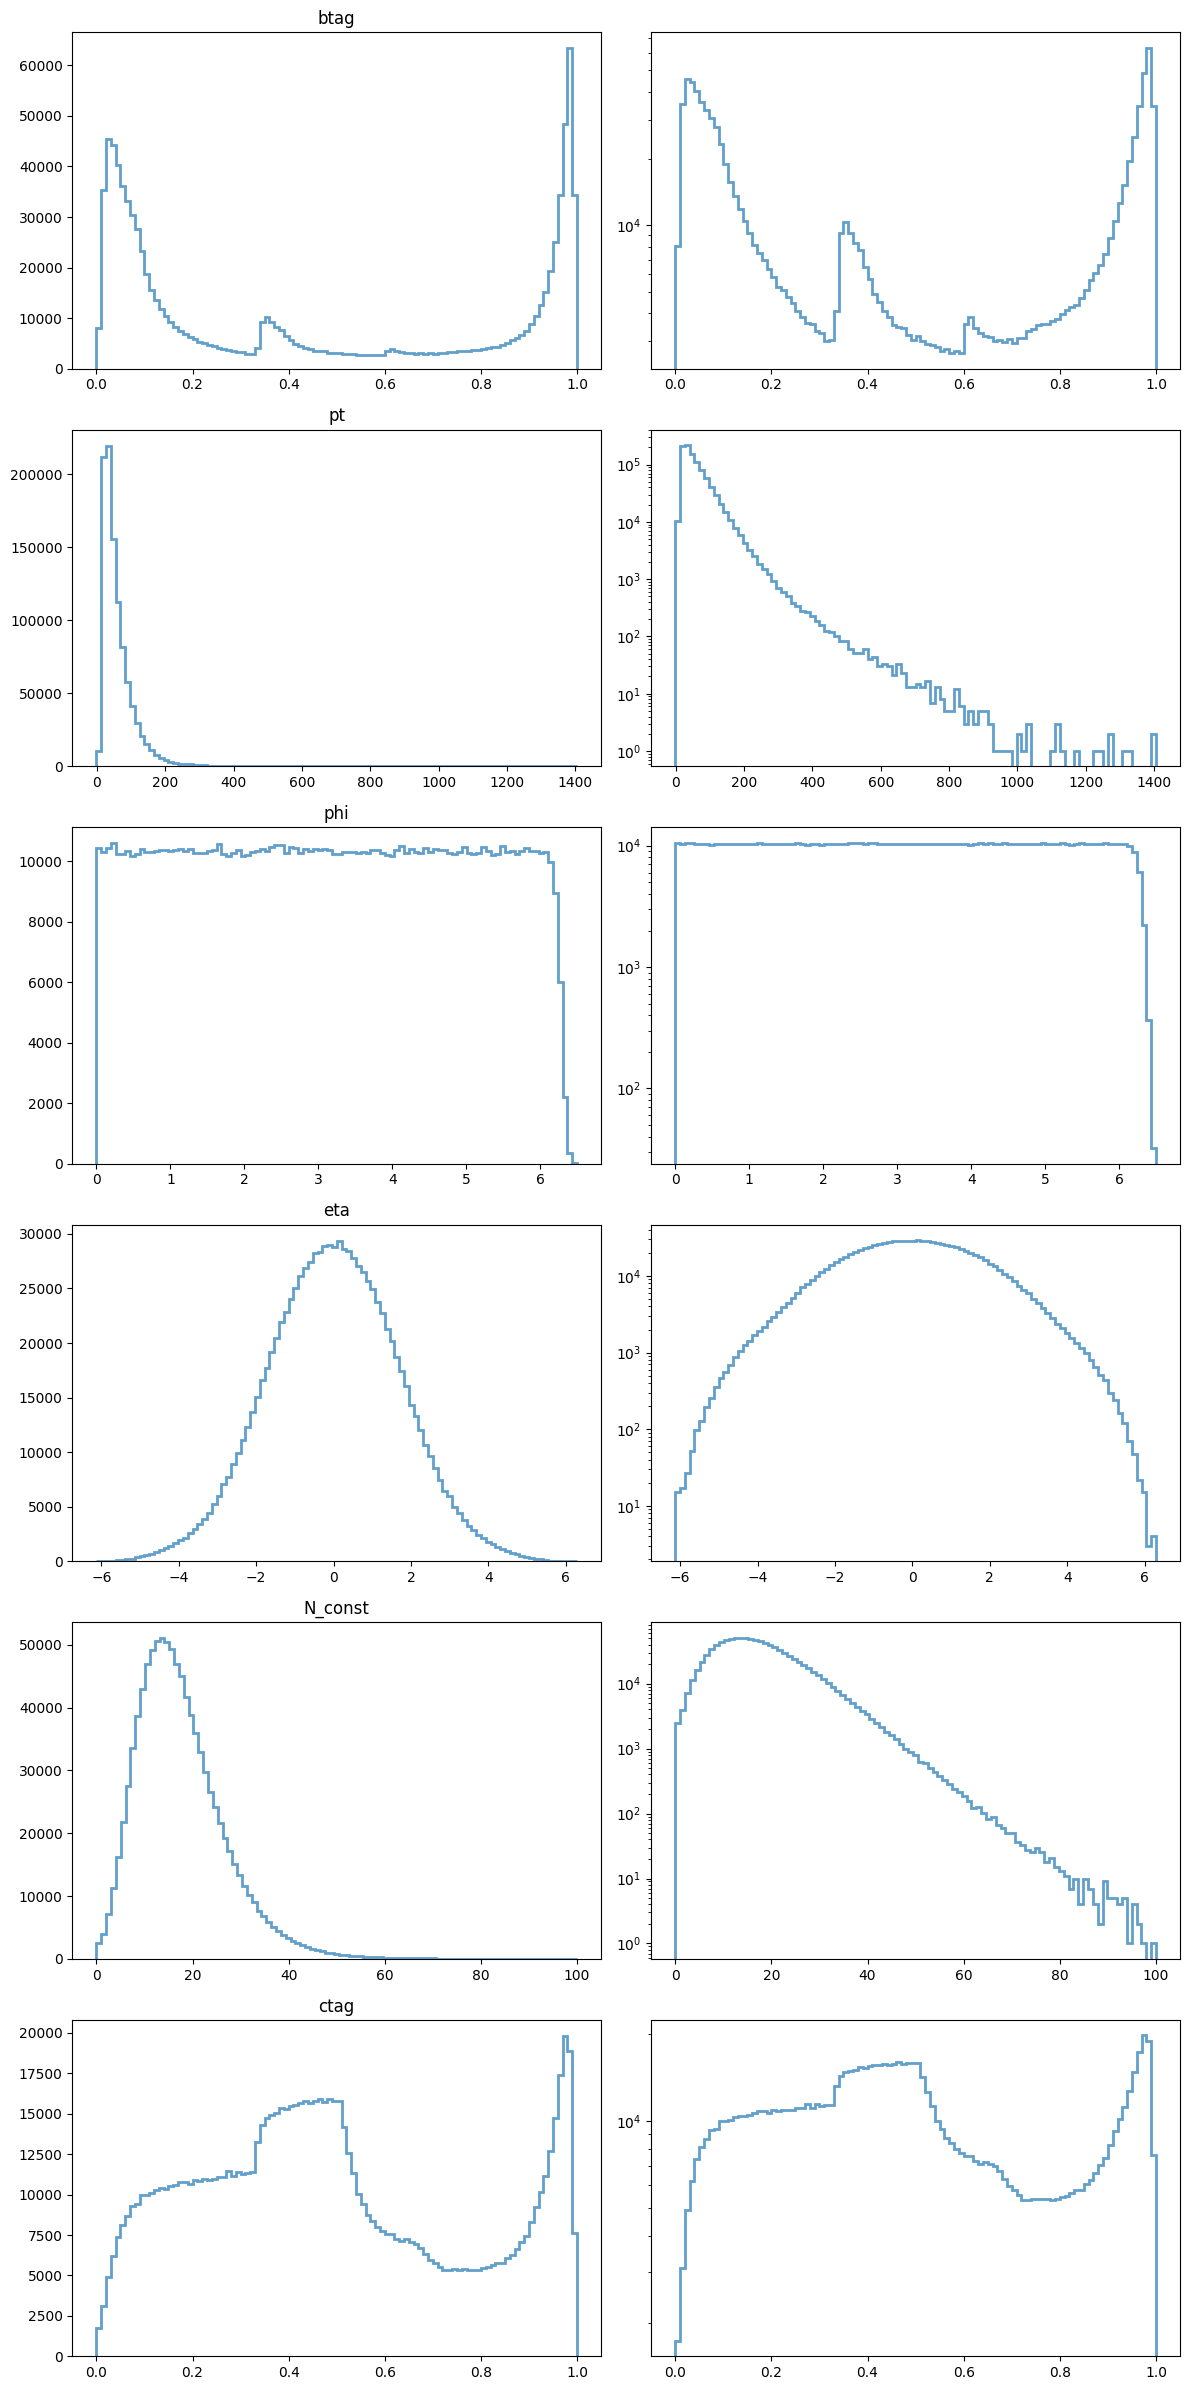

In [15]:
plot_1dhistos(reco_data, reco_features)

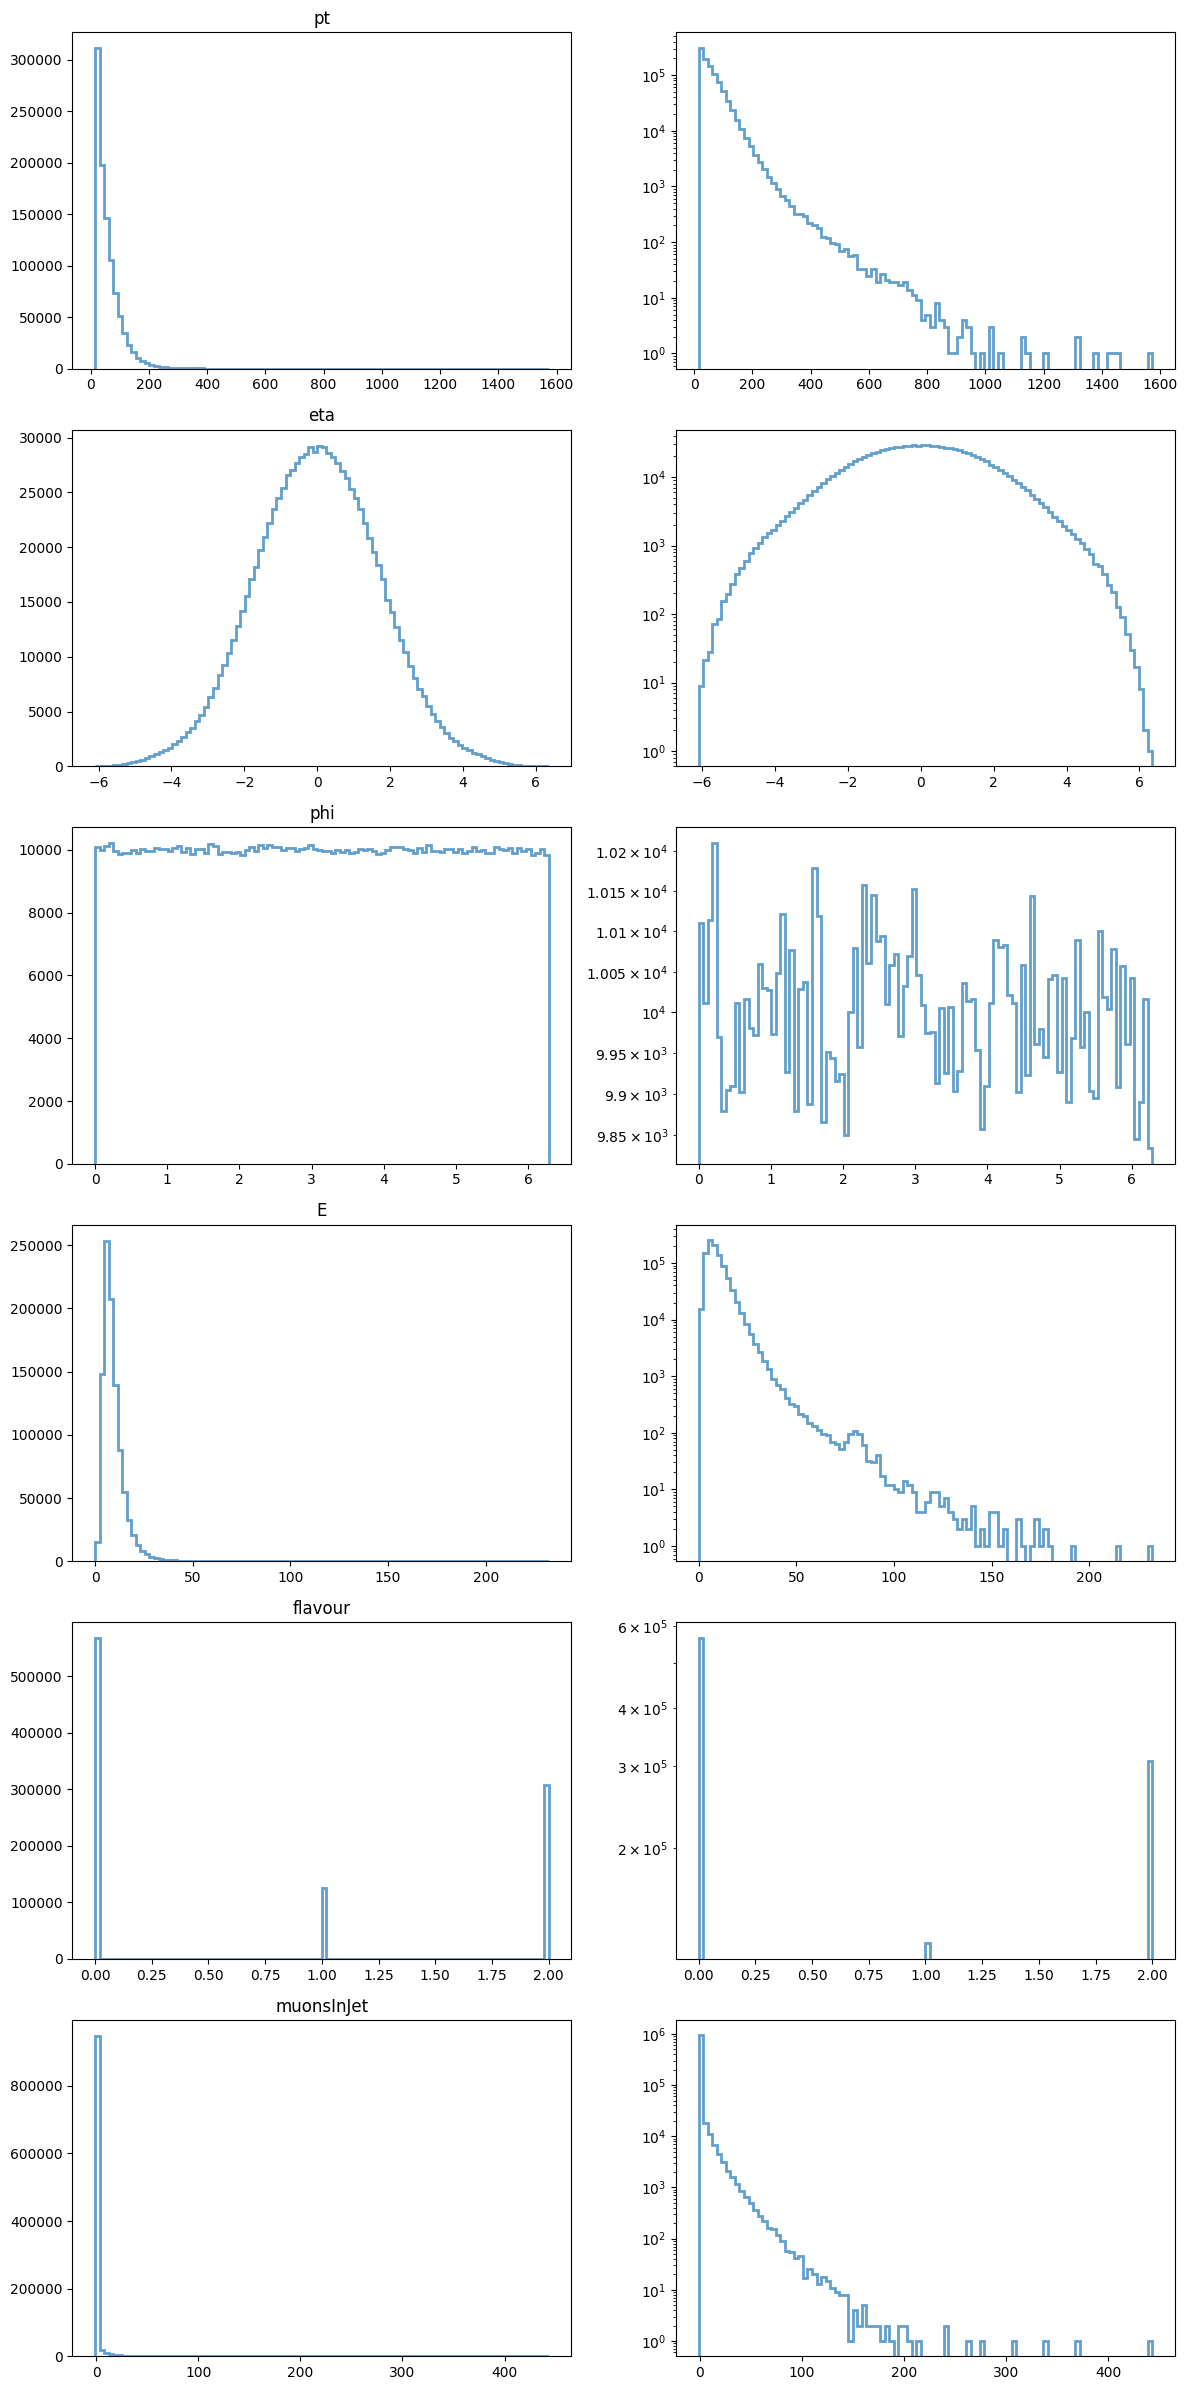

In [16]:
plot_1dhistos(gen_data, gen_features)